In [1]:
import datetime as dt
import numpy as np
import pandas as pd

from Pandora.helper import TDays
from Pandora.research.backtest import CODES_SHORT, calc_sharpe, COMMISSION
from vnpy.trader.constant import Interval, Product
from vnpy.trader.optimize import OptimizationSetting
from vnpy.trader.setting import SETTINGS
from logging import INFO
from vnpy.app.vnpy_portfoliostrategy import BacktestingEngine

SETTINGS["log.active"] = True
SETTINGS["log.level"] = INFO
SETTINGS["log.console"] = True



In [2]:
def get_mc(codes):
    from vnpy.trader.database import get_database

    database = get_database()
    today = dt.datetime.combine(TDays.get_tday(fmt=None), dt.time(0))
    contracts = database.load_contract_data(product=Product.FUTURES, start=today, end=today)
    mc = [i for i in contracts if i.symbol.endswith('00') and i.product_id in codes]

    return mc


## DataLoading

In [31]:
from Pandora.research import CODES_MM

mc = get_mc(CODES_MM)

engine = BacktestingEngine()
engine.contracts = {i.vt_symbol: i for i in mc}

engine.set_parameters(
    vt_symbols=[i.vt_symbol for i in mc],
    interval=Interval.MINUTE_15,
    start=dt.datetime(2015, 1, 1),
    end=dt.datetime(2024, 6, 27),
    rates={
        i.vt_symbol: COMMISSION for i in mc
    },
    slippages={
        i.vt_symbol: 0 for i in mc
    },
    sizes={
        i.vt_symbol: i.size for i in mc
    },
    priceticks={
        i.vt_symbol: i.pricetick for i in mc
    },
    capital=1e8,
)

engine.load_data()



2024-06-30 17:06:14.577897	开始加载历史数据
2024-06-30 17:06:14.586808	AP00.CZCE历史数据加载完成，数据量：23655
2024-06-30 17:06:15.877253	CF00.CZCE历史数据加载完成，数据量：54324
2024-06-30 17:06:15.898703	FG00.CZCE历史数据加载完成，数据量：53294
2024-06-30 17:06:15.922637	MA00.CZCE历史数据加载完成，数据量：54324
2024-06-30 17:06:15.932610	SA00.CZCE历史数据加载完成，数据量：24624
2024-06-30 17:06:16.457302	SR00.CZCE历史数据加载完成，数据量：54324
2024-06-30 17:06:16.483232	TA00.CZCE历史数据加载完成，数据量：54324
2024-06-30 17:06:16.525134	al00.SHFE历史数据加载完成，数据量：69405
2024-06-30 17:06:17.076670	bu00.SHFE历史数据加载完成，数据量：54480
2024-06-30 17:06:17.523010	c00.DCE历史数据加载完成，数据量：43960
2024-06-30 17:06:18.163355	fu00.SHFE历史数据加载完成，数据量：38516
2024-06-30 17:06:18.184299	hc00.SHFE历史数据加载完成，数据量：54480
2024-06-30 17:06:18.205243	i00.DCE历史数据加载完成，数据量：54938
2024-06-30 17:06:18.226187	j00.DCE历史数据加载完成，数据量：54938
2024-06-30 17:06:18.261597	jm00.DCE历史数据加载完成，数据量：54938
2024-06-30 17:06:18.769772	m00.DCE历史数据加载完成，数据量：54938
2024-06-30 17:06:18.799692	ni00.SHFE历史数据加载完成，数据量：67705
2024-06-30 17:06:18.823627	p00.DCE历史数据

## StrategyClass

In [21]:
from typing import List, Dict
from datetime import datetime, time

import numpy as np
import pandas as pd

from vnpy.app.vnpy_portfoliostrategy.base import EngineType
from vnpy.trader.setting import SETTINGS
from vnpy.trader.utility import ArrayManager
from vnpy.trader.object import TickData, BarData
from vnpy.trader.constant import Direction, Interval

from vnpy.app.vnpy_portfoliostrategy import StrategyTemplate, StrategyEngine
from vnpy.app.vnpy_portfoliostrategy.utility import PortfolioBarGenerator, ATRExitHelper


class TSStrategy(StrategyTemplate):
    author = "XCX"

    capital = 1e8
    interval = Interval.MINUTE_15

    window = 400

    atr_multiplier = 11

    vol_window = 100
    vol_target = 0.45

    bband_width = 2

    ls_imba = .75

    parameters = [
        "capital",
        "window",

        "atr_multiplier",

        "vol_window",
        "vol_target",

        "bband_width",

        "ls_imba"
    ]
    variables = [
    ]

    def __init__(
            self,
            strategy_engine: StrategyEngine,
            strategy_name: str,
            vt_symbols: List[str],
            setting: dict
    ) -> None:
        """构造函数"""
        super().__init__(strategy_engine, strategy_name, vt_symbols, setting)

        self.bband_window = self.atr_window = self.ma_window = self.window

        # 创建每个合约的ArrayManager
        self.ams: Dict[str, ArrayManager] = {}
        self.am_size = max(self.bband_window, self.ma_window) + max(self.window, self.atr_window, self.vol_window) * 3 + 100

        self.atr_helpers: Dict[str, ATRExitHelper] = {}
        for vt_symbol in self.vt_symbols:
            self.ams[vt_symbol] = ArrayManager(self.am_size)
            self.atr_helpers[vt_symbol] = ATRExitHelper(self.ams[vt_symbol])

        self.pbg = PortfolioBarGenerator(None, Interval.to_window(self.interval), self.on_bars)
        self.pbg.on_bars = self.pbg.update_bars

        if self.get_engine_type() == EngineType.SIGNAL:
            self.pos_data = self.target_data

    def on_init(self) -> None:
        """策略初始化回调"""
        self.write_log("策略初始化")

        if self.interval == Interval.MINUTE_15:
            days = int(self.am_size / 23) * 2  # mult 2 to fit trade day num, may fix in the future

        else:
            raise NotImplementedError

        self.load_bars(days, self.interval)

    def on_start(self) -> None:
        """策略启动回调"""
        self.write_log("策略启动")

        self.update_portfolio()

    def on_stop(self) -> None:
        """策略停止回调"""
        self.update_portfolio()

        self.write_log("策略停止")

    def on_tick(self, tick: TickData) -> None:
        """行情推送回调"""
        self.pbg.update_tick(tick)

    def on_bars(self, bars: Dict[str, BarData]) -> None:
        """K线切片回调"""
        super().on_bars(bars)

        for vt_symbol in self.vt_symbols:
            if vt_symbol in bars:
                bar = bars[vt_symbol]

                if (
                        bar.datetime.time() < time(9)  # 滤掉早盘集合竞价
                        or bar.datetime.time() >= time(23)  # 滤掉深夜交易
                        # or (time(21) > bar.datetime.time() >= time(20, 45))  # 滤掉夜盘集合竞价
                ):
                    return

                am: ArrayManager = self.ams[vt_symbol]
                am.update_bar(bar)

                self.atr_helpers[vt_symbol].on_bar(bar)

        if not self.trading:
            return

        self.update_portfolio()

        engine_type = self.get_engine_type()
        if engine_type != EngineType.SIGNAL:
            self.rebalance_portfolio(bars)

        self.put_event()

    def update_portfolio(self):
        for vt_symbol, am in self.ams.items():
            if not am.inited:
                continue

            atr_helper = self.atr_helpers[vt_symbol]
            current_pos = self.get_pos(vt_symbol)

            std = self.get_volatility(am)

            # if current_pos == 0:
            if std > self.vol_target:
                self.set_target(vt_symbol, 0)
                atr_helper.reset()
                
                continue
                
            direction = self.get_signal(am)
            if direction == Direction.LONG and current_pos <= 0:
                target_size = self.get_target_size_by_std_minus(vt_symbol, self.vol_window, std_max=self.vol_target)

                self.set_target(vt_symbol, target_size)

                atr_helper.on_target(self.last_prices[vt_symbol], Direction.LONG)

            elif direction == Direction.SHORT and current_pos >= 0:
                target_size = self.get_target_size_by_std_minus(vt_symbol, self.vol_window, std_max=self.vol_target)

                self.set_target(vt_symbol, -target_size)

                atr_helper.on_target(self.last_prices[vt_symbol], Direction.SHORT)

            else:
                if (
                        (current_pos > 0 and atr_helper.check_stoploss(self.atr_window, self.atr_multiplier))
                        or (current_pos < 0 and atr_helper.check_stoploss(self.atr_window, self.atr_multiplier * self.ls_imba))
                        # or atr_helper.check_stoploss(self.atr_window, self.atr_multiplier)
                ):
                    self.set_target(vt_symbol, 0)
                    atr_helper.reset()

        engine_type = self.get_engine_type()
        if engine_type != EngineType.BACKTESTING:
            self.save_strategy_portfolio()

    def get_factor(self, am: ArrayManager):
        # _, factor, _ = am.macd(self.window, int(self.window / 12 * 26), int(self.window / 12 * 9), array=True)
        factor = am.argmin(self.window, array=True)

        return factor

    def get_volatility(self, am: ArrayManager):
        roc = am.roc(1, True)
        std = np.std(np.log(1 + roc / 100)[-self.vol_window:]) * np.sqrt(252 * 23)

        return std

    def get_signal(self, am: ArrayManager):
        return self.trade_by_cross_ma(am)
        # return self.trade_by_bband(am)

    # def calculate_price(self, vt_symbol: str, direction: Direction, reference: float) -> float:
    #     """计算调仓委托价格（支持按需重载实现）"""
    #     if direction == Direction.LONG:
    #         price: float = reference + self.get_pricetick(vt_symbol) * 0
    #     else:
    #         price: float = reference - self.get_pricetick(vt_symbol) * 0
    #
    #     return price

    def save_strategy_portfolio(
            self,
            account_name: str = SETTINGS["account.name"],
            investor_id: str = SETTINGS["account.investorid"],
    ):
        print("Dev Stage, No save")

    def trade_by_cross_ma(self, am: ArrayManager):
        factor = self.get_factor(am)

        ma = factor[-self.ma_window:].mean()

        if factor[-1] > ma > factor[-2]:
            direction = Direction.LONG

        elif factor[-1] < ma < factor[-2]:
            direction = Direction.SHORT

        else:
            direction = None

        return direction

    def trade_by_bband(self, am: ArrayManager):
        factor = self.get_factor(am)

        factor_value = factor[-1]
        prev_value = factor[-2]

        bband_mid = factor[-self.bband_window:].mean()
        bband_width = factor[-self.bband_window:].std()

        if factor_value > bband_mid + self.bband_width * bband_width > prev_value:
            direction = Direction.LONG

        elif factor_value < bband_mid - self.bband_width * bband_width * self.ls_imba < prev_value:
            direction = Direction.SHORT

        else:
            direction = None

        return direction

    def get_target_size_by_std_minus(self, vt_symbol: str, param=500, day_count=23, n=3, std_min=0.1, std_max=0.45) -> int:
        am = self.ams[vt_symbol]

        roc = am.roc(1, True)
        weight = np.std(np.log(1 + roc / 100)[-param:]) * np.sqrt(252 * day_count)

        weight = ((std_max - weight) / (std_max - std_min) * (n - 1) + 1) / n
        weight = min(max(weight, 1 / n), 1)

        weight *= 1 / len([i for i in self.ams.values() if i.inited])

        size = int(self.capital * weight / self.get_size(vt_symbol) / am.close[-1])

        return size


2024-06-30 17:06:43.623879	策略初始化完成
2024-06-30 17:06:43.625874	开始回放历史数据


回放历史数据:   0%|          | 0/62887 [00:00<?, ?it/s]

2024-06-30 17:09:16.817356	历史数据回放结束
2024-06-30 17:09:16.818354	开始计算逐日盯市盈亏
2024-06-30 17:09:16.924574	逐日盯市盈亏计算完成
2024-06-30 17:09:16.925572	开始计算策略统计指标
2024-06-30 17:09:16.929561	------------------------------
2024-06-30 17:09:16.929561	首个交易日：	2015-11-20
2024-06-30 17:09:16.929561	最后交易日：	2024-06-27
2024-06-30 17:09:16.929561	总交易日：	2462
2024-06-30 17:09:16.929561	盈利交易日：	1233
2024-06-30 17:09:16.929561	亏损交易日：	1134
2024-06-30 17:09:16.929561	起始资金：	100,000,000.00
2024-06-30 17:09:16.929561	结束资金：	137,466,342.66
2024-06-30 17:09:16.929561	总收益率：	37.47%
2024-06-30 17:09:16.929561	年化收益：	3.83%
2024-06-30 17:09:16.929561	最大回撤: 	-4,508,487.27
2024-06-30 17:09:16.929561	百分比最大回撤: -3.32%
2024-06-30 17:09:16.929561	最长回撤天数: 	102
2024-06-30 17:09:16.929561	总盈亏：	37,466,342.66
2024-06-30 17:09:16.929561	总手续费：	4,084,188.32
2024-06-30 17:09:16.929561	总滑点：	0.00
2024-06-30 17:09:16.929561	总成交金额：	20,420,941,623.07
2024-06-30 17:09:16.929561	总成交笔数：	6417
2024-06-30 17:09:16.929561	日均盈亏：	15,217.85
2024-06-30 17:09:

1.302653117792125

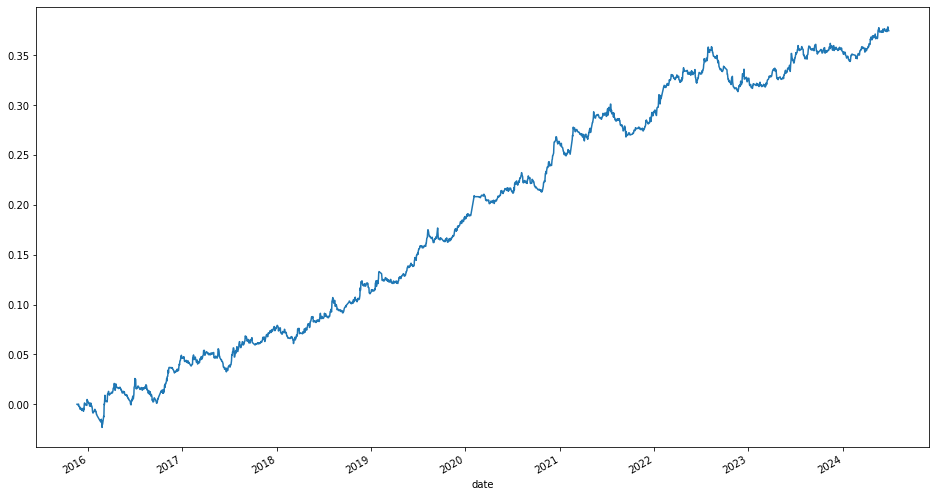

In [32]:
engine.clear_data()
setting = {
    "window": 700,
}
engine.add_strategy(TSStrategy, setting)

engine.run_backtesting()
df = engine.calculate_result()
engine.calculate_statistics()

daily_base = pd.Series(df['net_pnl'] / engine.capital, index=pd.to_datetime(df.index))
daily_base.cumsum().plot(figsize=(16, 9))
calc_sharpe(daily_base)

In [33]:
trade_info = []
for trade in engine.trades.values():
    trade_info.append(
        {
            'symbol': trade.symbol,
            'direction': trade.direction,
            'offset': trade.offset,
            'price': trade.price,
            'volume': trade.volume,
            'datetime': trade.datetime,
        }
    )

trade_info = pd.DataFrame(trade_info)

rounds = []
for symbol, group in trade_info.groupby('symbol'):
    round_ = pd.DataFrame(columns=['symbol', 'direction', 'open_time', 'open_price', 'close_time', 'close_price', 'volume', 'pnl', 'hp'])
    idx = 0
    
    try:
        for i in range(0, len(group), 2):
            open_trade = group.iloc[i, :]
            close_trade = group.iloc[i + 1, :]
            
            direction = 1 if open_trade['direction'] == Direction.LONG else -1
            
            round_.loc[idx, 'symbol'] = symbol
            round_.loc[idx, 'direction'] = open_trade['direction']
            round_.loc[idx, 'open_time'] = open_trade['datetime']
            round_.loc[idx, 'open_price'] = open_trade['price']
            round_.loc[idx, 'close_time'] = close_trade['datetime']
            round_.loc[idx, 'close_price'] = close_trade['price']
            round_.loc[idx, 'volume'] = open_trade['volume']
            round_.loc[idx, 'pnl'] = (close_trade['price'] - open_trade['price']) / open_trade['price'] * direction
            round_.loc[idx, 'hp'] = (close_trade['datetime'] - open_trade['datetime']).total_seconds() / dt.timedelta(days=1).total_seconds()
            
            idx += 1
    
    except IndexError:
        pass
    
    rounds.append(round_)
    
rounds = pd.concat(rounds)
rounds
        
    

,symbol,direction,open_time,open_price,close_time,close_price,volume,pnl,hp
0,AP00,Direction.SHORT,2018-10-17 11:15:00+08:00,10283.582775,2018-10-26 21:00:00+08:00,10444.746897,25,-0.015672,9.40625
1,AP00,Direction.LONG,2018-11-26 10:30:00+08:00,10432.519082,2018-11-29 14:45:00+08:00,9806.0,25,-0.060054,3.177083
2,AP00,Direction.SHORT,2018-11-29 14:45:00+08:00,9806.0,2018-12-07 14:00:00+08:00,10285.509115,23,-0.0489,7.96875
3,AP00,Direction.SHORT,2018-12-19 14:45:00+08:00,9788.26952,2019-01-25 10:30:00+08:00,9503.0,35,0.029144,36.822917
4,AP00,Direction.LONG,2019-01-29 14:15:00+08:00,9444.958009,2019-04-17 13:45:00+08:00,10757.384114,31,0.138955,77.979167
...,...,...,...,...,...,...,...,...,...
156,zn00,Direction.SHORT,2024-05-27 21:45:00+08:00,27295.0,2024-06-03 09:15:00+08:00,26805.0,21,0.017952,6.479167
157,zn00,Direction.LONG,2024-06-03 09:15:00+08:00,26805.0,2024-06-11 21:15:00+08:00,25823.573302,22,-0.036614,8.5
158,zn00,Direction.SHORT,2024-06-17 14:00:00+08:00,25521.767834,2024-06-18 13:30:00+08:00,25835.0,24,-0.012273,0.979167
159,zn00,Direction.LONG,2024-06-18 13:30:00+08:00,25835.0,2024-06-21 21:30:00+08:00,26040.0,24,0.007935,3.333333


In [34]:
rounds[['hp', 'pnl']].astype(float).describe(include='all')

,hp,pnl
count,3202.000000,3202.000000
mean,10.183180,0.004134
std,10.113871,0.041056
min,0.010417,-0.085953
25%,3.346354,-0.020816
50%,6.989583,-0.003730
75%,13.718750,0.017939
max,77.979167,0.466474


## Optimization

In [35]:
from vnpy.app.vnpy_portfoliostrategy.strategies.ts_strategy import TSStrategy as TSStrategy_

In [36]:
setting = {
    "window": 50,
}
engine.clear_data()
engine.add_strategy(TSStrategy_, setting)


setting = OptimizationSetting()
setting.set_target("sharpe_ratio")
setting.add_parameter("window", 100, 900, 100)
setting.add_parameter("atr_multiplier", 9, 13, 2)
setting.add_parameter("ls_imba", 0.75)

opt_res = engine.run_bf_optimization(setting, max_workers=10)

sharpe_mat = pd.DataFrame()

for res in opt_res:
    param = res[0]
    sharpe = res[1]

    sharpe_mat.loc[param['window'], param['atr_multiplier']] = sharpe

sharpe_mat.sort_index()

2024-06-30 17:09:19.434278	开始执行穷举算法优化
2024-06-30 17:09:19.434278	参数优化空间：27


100%|██████████| 27/27 [15:13<00:00, 33.82s/it]  


2024-06-30 17:24:37.131381	穷举算法优化完成，耗时917秒
2024-06-30 17:24:45.052703	参数：{'window': 700, 'atr_multiplier': 11, 'ls_imba': 0.75}, 目标：1.294609612993032
2024-06-30 17:24:45.052703	参数：{'window': 700, 'atr_multiplier': 13, 'ls_imba': 0.75}, 目标：1.1815005927552147
2024-06-30 17:24:45.052703	参数：{'window': 700, 'atr_multiplier': 9, 'ls_imba': 0.75}, 目标：1.1113032292046008
2024-06-30 17:24:45.052703	参数：{'window': 600, 'atr_multiplier': 11, 'ls_imba': 0.75}, 目标：1.0654568874953625
2024-06-30 17:24:45.052703	参数：{'window': 600, 'atr_multiplier': 13, 'ls_imba': 0.75}, 目标：0.9451564112035535
2024-06-30 17:24:45.052703	参数：{'window': 500, 'atr_multiplier': 11, 'ls_imba': 0.75}, 目标：0.943885704974831
2024-06-30 17:24:45.052703	参数：{'window': 800, 'atr_multiplier': 11, 'ls_imba': 0.75}, 目标：0.8962928912204262
2024-06-30 17:24:45.052703	参数：{'window': 900, 'atr_multiplier': 11, 'ls_imba': 0.75}, 目标：0.894943379551228
2024-06-30 17:24:45.052703	参数：{'window': 600, 'atr_multiplier': 9, 'ls_imba': 0.75}, 目标：0.8825198

,11,13,9
100,-0.332235,-0.397033,-0.282774
200,-0.047257,-0.037673,0.000418
300,0.482561,0.440340,0.613170
400,0.392024,0.363240,0.463588
500,0.943886,0.802123,0.697495
600,1.065457,0.945156,0.882520
700,1.294610,1.181501,1.111303
800,0.896293,0.778261,0.633262
900,0.894943,0.821496,0.825913
